# Bird species image classification

In [3]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=c5408a4f994e1e2277b1546a5d66a2785efb4a5dad831ca8addf531a67984e53
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from torch.utils.data.sampler import SubsetRandomSampler
import PIL
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensor
from efficientnet_pytorch import EfficientNet

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd "/content/drive/MyDrive/bird_species"

/content/drive/MyDrive/bird_species


В задаче классификации участвовали фотографии 20 классов (фотографии были собраны из google images по английским названиям.

In [8]:
label_dict = {0:'black_kite',
              1:'chaffinch',
              2:'common_magpie',
              3:'crested_tit',
              4:'common_raven',
              5:'eurasian_jay',
              6:'eurasian_pygmy-owl',
              7:'eurasian_tree_sparrow',
              8:'european_turtle-dove',
              9:'great_spotted_woodpecker',
              10:'hazel_grouse',
              11:'northern_harrier',
              12:'ruddy_shelduck',
              13:'rock_pigeon',
              14:'snowy_owl',
              15:'snow_goose',
              16:'waxwing',
              17:'white_stork',
              18:'white_wagtail',
              19:'willow_grouse'}

In [9]:
num_classes = len(label_dict)

In [10]:
BATCH_SIZE = 50
n_epochs = 10

## 1 Classification

### 1.1 Dataset & dataloader

Фотографии находятся в папках своего класса без разделения на тестовую и обучающую выборки.

In [11]:
data_path = './bird_dataset/' #путь до папки с датасетом
img_path = './bird_dataset/bird_img' #путь до папки с датасетом


In [12]:
class BirdDataset(Dataset):
  def __init__(self, img_folder, img_size):
    super().__init__()

    self.img_folder = img_folder
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize(img_size),
         transforms.RandomAutocontrast(p=0.3),
         transforms.GaussianBlur(1, sigma=(0.1, 0.2)),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
     
    self.dataset = datasets.ImageFolder(self.img_folder, transform=transform)

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):  
    img_tensor = self.dataset[idx][0]
    object_label = self.dataset[idx][1]

    return {'image': img_tensor, 'label': object_label}

In [13]:
bird_set = BirdDataset(img_path,[256, 256])

In [14]:
len(bird_set)

5434

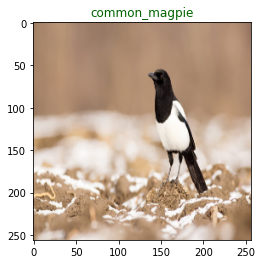

In [15]:

def show_img_n_lbl(img_tensor, label, label_pred=None):
    image = np.moveaxis(img_tensor.numpy(), 0, 2)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    im_lb = label_dict[label]

    
    if label_pred is not None:
      print(label_pred)
      pred_im_lb = label_dict[label_pred]
      plt.suptitle(pred_im_lb, color='darkred', fontsize=12)
    plt.imshow(image.clip(0, 1))
    plt.title(im_lb, color='darkgreen', fontsize=12)

show_img_n_lbl(bird_set[800]['image'], bird_set[800]['label'])

#### 1.1.1 Train & test split 

In [16]:
#train/test split 
train_size = int(0.8 * len(bird_set))
test_size = len(bird_set) - train_size
train_set, test_set = torch.utils.data.random_split(bird_set, 
                                                    [train_size, test_size], 
                                                    generator=torch.Generator().manual_seed(42))

In [17]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## 1.2 Network architecture

В качестве модели использовалась предобученная [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = EfficientNet.from_name('efficientnet-b0')
model.load_state_dict(torch.load('./efficientnet-b0-08094119.pth')) # from https://www.kaggle.com/hmendonca/efficientnet-pytorch
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model = model.to(device)

In [19]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [20]:

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))

    model.train()
    epoch_loss = 0.
    correct = 0
    total = 0

    for batch in train_loader:
      #this is not a very elegant implementation. i`ll fix it
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f'Train: {epoch_loss / len(train_loader)} | acc: {correct / total}')

    model.eval()
    epoch_loss = 0.
    correct = 0
    total = 0

    for batch in test_loader:
        images, labels = batch['image'], batch['label']
        images = images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        
        correct += (labels == predictions.argmax(dim=1,)).sum()
        total += len(labels)

        with torch.no_grad():
            loss = loss_function(predictions, labels)

        epoch_loss += loss.item()
    print(f'Test: {epoch_loss / len(test_loader)} | acc: {correct / total}')


Epoch 1/10
Train: 2.200950148461879 | acc: 0.5955831408500671
Test: 0.7790345061909069 | acc: 0.8601655960083008
Epoch 2/10
Train: 0.6029268722424562 | acc: 0.9227052927017212
Test: 0.23573040013963525 | acc: 0.9622814655303955
Epoch 3/10
Train: 0.2046932871828134 | acc: 0.9687140583992004
Test: 0.15023135766386986 | acc: 0.9724010825157166
Epoch 4/10
Train: 0.10608489323278954 | acc: 0.9852771759033203
Test: 0.118884002789855 | acc: 0.9788408279418945
Epoch 5/10
Train: 0.06121968732740002 | acc: 0.9919484257698059
Test: 0.09566029169681398 | acc: 0.9779208302497864
Epoch 6/10
Train: 0.036632506305287624 | acc: 0.9972394704818726
Test: 0.08960690992799672 | acc: 0.9825206995010376
Epoch 7/10
Train: 0.031176135222288383 | acc: 0.9965493083000183
Test: 0.0880153076723218 | acc: 0.9806807637214661
Epoch 8/10
Train: 0.02095273642361849 | acc: 0.9972394704818726
Test: 0.07978133692152121 | acc: 0.9797607660293579
Epoch 9/10
Train: 0.017632234702422016 | acc: 0.9972394704818726
Test: 0.07768

### 2.2  Network architecture

10


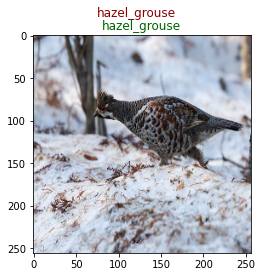

In [21]:
for sample in test_set:
  if sample['label'] == 10:
    image = sample['image']
    label = sample['label']
    break
#sample = test_set[350] 

with torch.no_grad():
    label_pred = model(torch.unsqueeze(image, dim=0).to(device)).cpu().numpy()[0].argmax()
show_img_n_lbl(image, label, label_pred=label_pred)